# PR101: Effect of KD of CYTB and ND2 on the mitochondrial proteome
The samples are purified mitochondria from HEK293T cells with either Cytochrome B knockdown, ND2 knockdown or a wild-type control. Cells are unlabelled and comparison of protein abundances has to be done solely on LFQ basis.

## Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from autoprot_dev import analysis as ana
from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis

pd.set_option("display.max_columns", None)

Checking R installation...
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)
Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.20'
is available with R version '4.4'; see https://bioconductor.org/install
Loading required package: devtools
Loading required package: usethis
Attaching package: ‘devtools’
The 

In [2]:
# load protein groups
pg_raw = pp.read_csv("../maxquant/2h_nonfrac/txt/proteinGroups.txt")
pg_raw = pp.cleaning(pg_raw, file="proteinGroups")
pg = pg_raw.copy()

# load peptides
peps = pp.read_csv("../maxquant/2h_nonfrac/txt/peptides.txt")
peps = pp.cleaning(peps, file="peptides.txt")

3229 rows before filter operation.
3139 rows after filter operation.
23427 rows before filter operation.
23427 rows after filter operation.


In [3]:
# papermill parameters
target_gene_name = "CYTB"
treatment_experiment_name = "CYTB"

In [4]:
# Check if target was identified
print(
    f'Found {len(pg[pg["Gene names"].str.contains(target_gene_name, na=False)])} CYTB proteins'
)

Found 2 CYTB proteins


In [5]:
# We need the gene names for plot annotation later
pg["Gene names first"] = pg["Gene names"].str.split(";").str[0]

We will rely on MaxQuant LFQ values since these inherently normalise the ratios between the conditions. The justification for this is the assumption that most protein abundances in the mitochondria will not change if we knock down important parts of the respiratory chain.

In [6]:
intens = pg.filter(regex="LFQ intensity").columns.tolist()
# replace zero intens with NAN
pg[intens] = pg[intens].replace(0, np.nan)

True

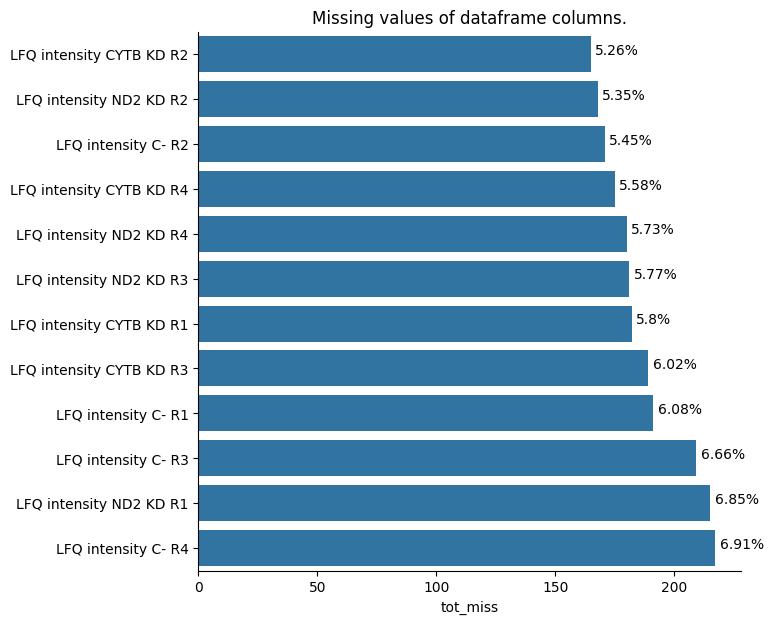

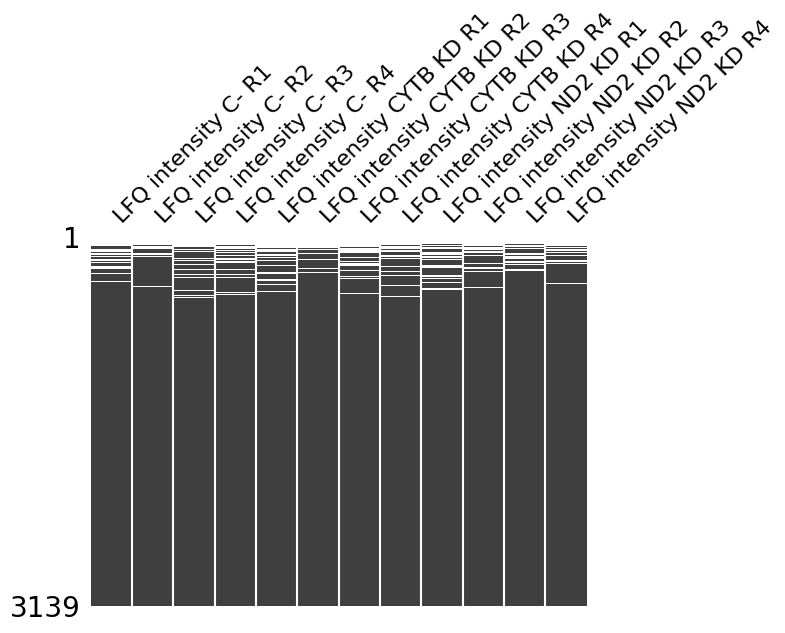

In [7]:
ana.miss_analysis(pg, intens, text=False, extra_vis=True)

### Missing values
With up to 7% missing values between conditions, the samples appear rather reproducible in this data set.

In [8]:
# nested list of column names for downstream accessing
intens_nested = [
    pg.filter(regex="LFQ intensity C-").columns.tolist(),
    pg.filter(regex=f"LFQ intensity {treatment_experiment_name}").columns.tolist(),
]
intens_nested

[['LFQ intensity C- R1',
  'LFQ intensity C- R2',
  'LFQ intensity C- R3',
  'LFQ intensity C- R4'],
 ['LFQ intensity CYTB KD R1',
  'LFQ intensity CYTB KD R2',
  'LFQ intensity CYTB KD R3',
  'LFQ intensity CYTB KD R4']]

### Logarithm

In [9]:
log_intens_nested = []

for intens in intens_nested:
    pg, log_intens = pp.log(pg, intens, return_cols=True)
    log_intens_nested.append(log_intens)

log_intens_nested

[['log2_LFQ intensity C- R1',
  'log2_LFQ intensity C- R2',
  'log2_LFQ intensity C- R3',
  'log2_LFQ intensity C- R4'],
 ['log2_LFQ intensity CYTB KD R1',
  'log2_LFQ intensity CYTB KD R2',
  'log2_LFQ intensity CYTB KD R3',
  'log2_LFQ intensity CYTB KD R4']]

### Filtering
We filter so that each protein group contains LFQ intensities for et least 75% of the conditions. Since the search was done with MBR enabled, this is a rather liberal filtering.

In [10]:
pg = pp.filter_vv(pg, [intens_nested[0], intens_nested[1]], 3)

3139 rows before filter operation.
2890 rows after filter operation.


## Imputation and normalisation
The remaining one missing value per row is imputed with sequential imputation to gain ratios under all conditions. 
Additionally, cyclic LOESS normalisation is done within each condition group (i.e. CYTB KD vs. ND2 KD vs. WT).

In [11]:
# impute and normalize the wt and treatment intensities separately
log_intens_imp_norm_nested = []

for idx in [0, 1]:
    pg, log_intens_imp = pp.imp_seq(pg, log_intens_nested[idx], return_cols=True)
    log_intens_imp.remove("UID")
    pg, log_intens_imp_norm = pp.cyclic_loess(pg, log_intens_imp, return_cols=True)

    log_intens_imp_norm_nested.append(log_intens_imp_norm)

log_intens_imp_norm_nested

[['log2_LFQ.intensity.C..R1_imputed_normalized',
  'log2_LFQ.intensity.C..R2_imputed_normalized',
  'log2_LFQ.intensity.C..R3_imputed_normalized',
  'log2_LFQ.intensity.C..R4_imputed_normalized'],
 ['log2_LFQ.intensity.CYTB.KD.R1_imputed_normalized',
  'log2_LFQ.intensity.CYTB.KD.R2_imputed_normalized',
  'log2_LFQ.intensity.CYTB.KD.R3_imputed_normalized',
  'log2_LFQ.intensity.CYTB.KD.R4_imputed_normalized']]

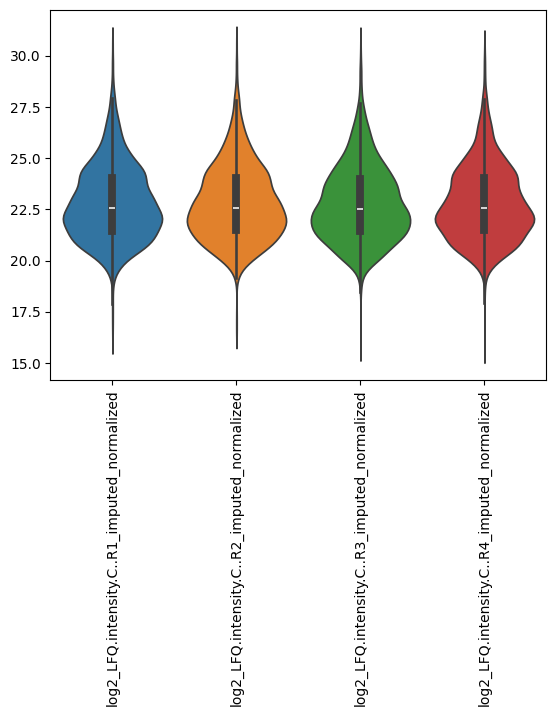

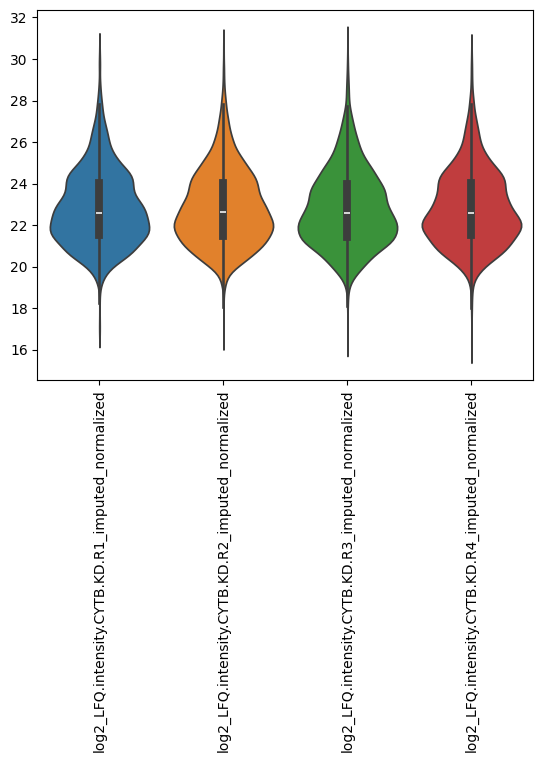

In [12]:
# boxplot for replicate comparison
for cond in log_intens_imp_norm_nested:
    sns.violinplot(pg[cond])
    plt.xticks(rotation=90)
    plt.show()

## Ratio calculation
We will calculate the ratios manually for generating ratio/intensity plots. As we will also perform 2-smaple statistical analysis, these ratios will also be calculated by the underlaying stats modules.

In [13]:
# calculate the ratios
pg[[f"log2_Ratio {treatment_experiment_name} vs. WT Rep{i+1}" for i in range(4)]] = (
    pg[log_intens_imp_norm_nested[1]].values - pg[log_intens_imp_norm_nested[0]].values
)

print(pg.filter(regex="vs. WT").columns)

Index(['log2_Ratio CYTB vs. WT Rep1', 'log2_Ratio CYTB vs. WT Rep2',
       'log2_Ratio CYTB vs. WT Rep3', 'log2_Ratio CYTB vs. WT Rep4'],
      dtype='object')


### Ratio/Intensity per replicate
Calculating ratio/intensity plots for all raw data points allows to get an overview on the data. Here we can already see that there is not much spread in the distribution, i.e. most of the protein abundances appear unchanged.

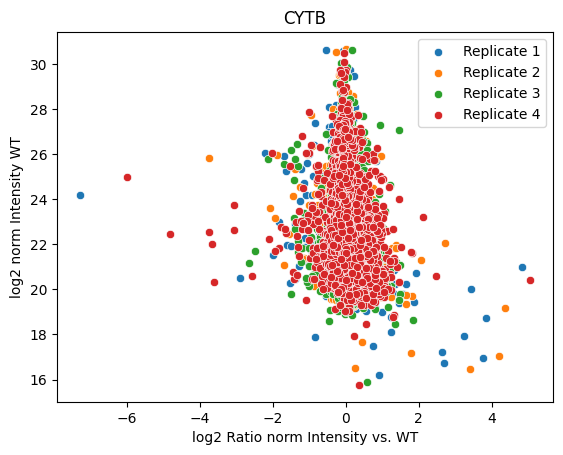

In [14]:
# ratio intensity plot
ratio = pg.filter(regex=f"log2_Ratio {treatment_experiment_name}").values
intens = pg[log_intens_imp_norm_nested[0]].values
for i, (rep_ratio, rep_intens) in enumerate(zip(ratio.T, intens.T)):
    sns.scatterplot(x=rep_ratio, y=rep_intens, label=f"Replicate {i+1}")
plt.ylabel("log2 norm Intensity WT")
plt.xlabel("log2 Ratio norm Intensity vs. WT")
plt.title(treatment_experiment_name)
plt.savefig(f"PR101_2h_nonfrac_{target_gene_name}_ratio_intens.pdf")
plt.show()

### Ratio/intensity per protein group
Using the same approach per protein group (and including the variance within each group as point size) leads to a similar picture. Strongest depletion is a log2 ratio of -0.1 (i.e. 0.93 in non-log-space).

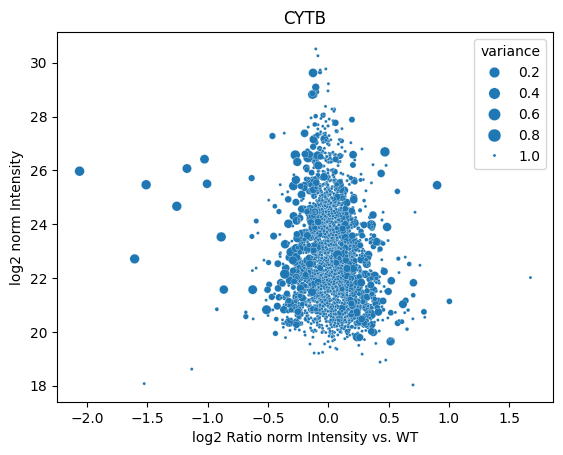

In [15]:
# ratio intensity plots
mean_ratio = pg.filter(regex=f"log2_Ratio {treatment_experiment_name}").mean(axis=1)
std = pg.filter(regex=f"log2_Ratio {treatment_experiment_name}").std(axis=1)
rel_std = std / mean_ratio
rel_std = rel_std.abs()
rel_std[rel_std.abs() > 1] = 1
intens = pg[log_intens_imp_norm_nested[0]].mean(axis=1).values
ax = sns.scatterplot(x=mean_ratio, y=intens, size=rel_std, sizes=(50, 5))
ax.legend(title="variance")
plt.ylabel("log2 norm Intensity")
plt.xlabel("log2 Ratio norm Intensity vs. WT")
plt.title(treatment_experiment_name)
plt.savefig(f"PR101_2h_nonfrac_{target_gene_name}_mean_ratio_intens.pdf")
plt.show()

## PCA analysis
To check if the different treatment conditions are reflected in the data, a principal component analysis is performed. As we previously normalised within each treatment group, already this normalistion should bias towards separation in the experiment groups. However, no clear separation of the underlying experiment can be seen - neither on the raw LFQ intensity level nor on the basis of the manually calculated intensity ratios.

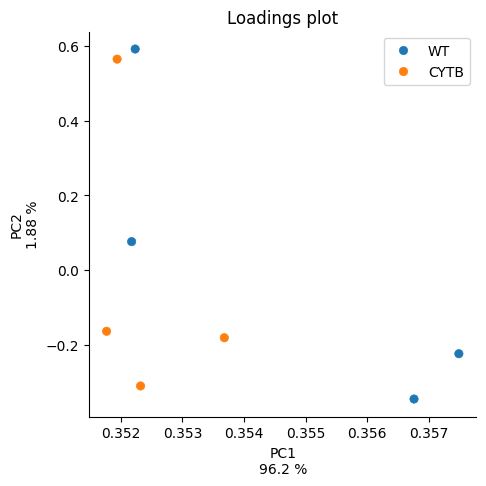

In [16]:
pca = ana.AutoPCA(
    dataframe=pg[log_intens_imp_norm_nested[0] + log_intens_imp_norm_nested[1]],
    clabels=log_intens_imp_norm_nested[0] + log_intens_imp_norm_nested[1],
    batch=[
        "WT",
        "WT",
        "WT",
        "WT",
        f"{target_gene_name}",
        f"{target_gene_name}",
        f"{target_gene_name}",
        f"{target_gene_name}",
    ],
)

pca.loading_plot(labeling=False)

## Statistical Analysis
Despite the lack of clear effects in the previous plots, we still perform statistical analyses. The reference plot in the paper was done with 2-sample ttest. However, to gain more sensitivity by using (effect size invariant) rank analysis, we start with a rank product test.

In [17]:
pg = ana.rank_prod(
    pg,
    [log_intens_imp_norm_nested[1], log_intens_imp_norm_nested[0]],
    cond=f"_{target_gene_name}vsWT_rankprod",
)

rankProd: Assuming a two sample test with:
Sample 1: 
	log2_LFQ.intensity.CYTB.KD.R1_imputed_normalized, 
	log2_LFQ.intensity.CYTB.KD.R2_imputed_normalized, 
	log2_LFQ.intensity.CYTB.KD.R3_imputed_normalized, 
	log2_LFQ.intensity.CYTB.KD.R4_imputed_normalized
Sample 2: 
	log2_LFQ.intensity.C..R1_imputed_normalized, 
	log2_LFQ.intensity.C..R2_imputed_normalized, 
	log2_LFQ.intensity.C..R3_imputed_normalized, 
	log2_LFQ.intensity.C..R4_imputed_normalized
Class labels: 0, 0, 0, 0, 1, 1, 1, 1


In [18]:
pg = ana.ttest(
    pg,
    [log_intens_imp_norm_nested[1], log_intens_imp_norm_nested[0]],
    cond=f"_{target_gene_name}vsWT_tt2samp",
)

Performing two-sample t-Test


In [19]:
# log2 of ratios
pg = ana.ttest(
    pg,
    pg.filter(regex=f"log2_Ratio {treatment_experiment_name}").columns,
    cond=f"_{target_gene_name}vsWT_tt1samp",
)

Performing one-sample t-Test


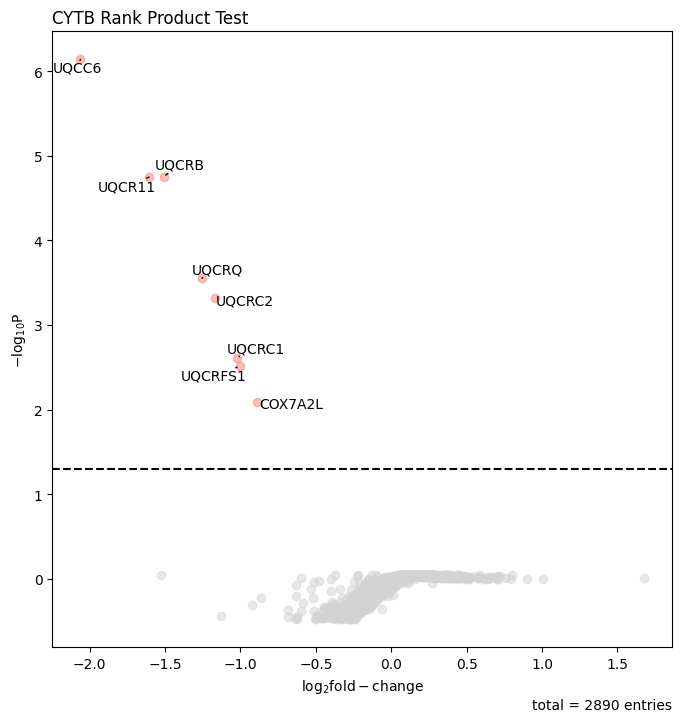

In [22]:
vis.volcano(
    pg,
    log_fc_colname=f"logFC_{target_gene_name}vsWT_rankprod",
    p_colname=f"adj.P.Val_class1<class2_{target_gene_name}vsWT_rankprod",
    annotate_colname="Gene names first",
    log_fc_thresh=None,
    annotate="p-value",
    kwargs_p_sig={"color": "salmon"},
    show_legend=False,
    title=target_gene_name + " Rank Product Test",
)

plt.savefig(f"PR101_2h_nonfrac_volcano_rankprod{target_gene_name}.pdf")

Not enough data points for KDE. Return original point cloud.


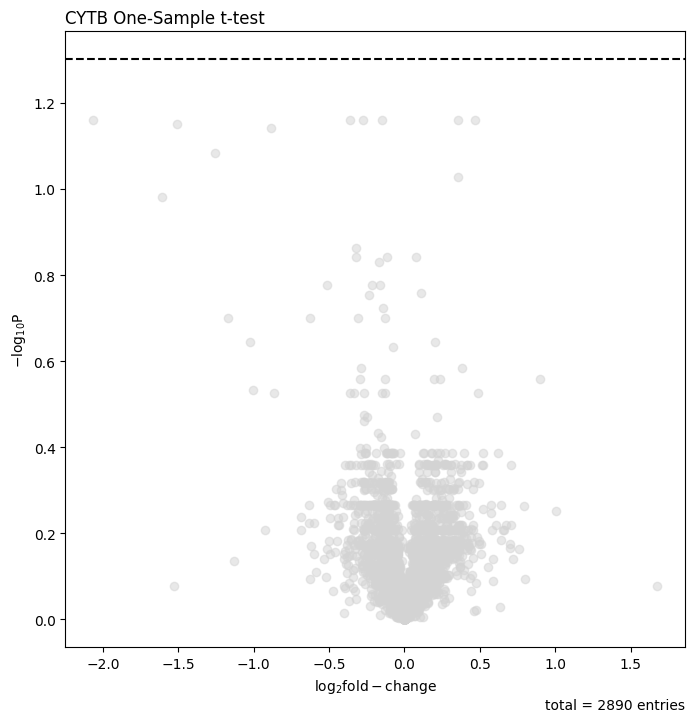

In [23]:
vis.volcano(
    pg,
    log_fc_colname=f"logFC_{target_gene_name}vsWT_tt1samp",
    p_colname=f"adj.pValue_{target_gene_name}vsWT_tt1samp",
    annotate_colname="Gene names first",
    log_fc_thresh=None,
    annotate="p-value",
    kwargs_p_sig={"color": "salmon"},
    show_legend=False,
    title=target_gene_name + " One-Sample t-test",
)

plt.savefig(f"PR101_2h_nonfrac_volcano_ttest_1samp_{target_gene_name}.pdf")

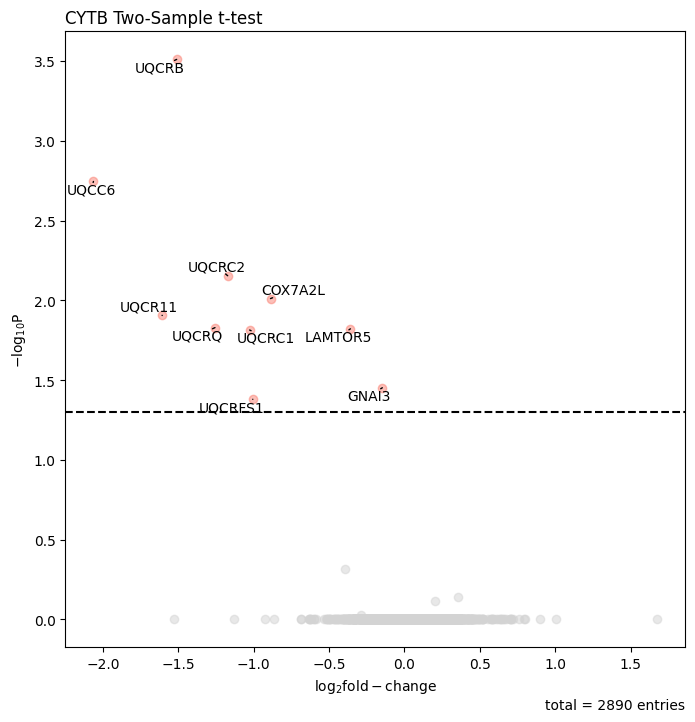

In [24]:
vis.volcano(
    pg,
    log_fc_colname=f"logFC_{target_gene_name}vsWT_tt2samp",
    p_colname=f"adj.pValue_{target_gene_name}vsWT_tt2samp",
    annotate_colname="Gene names first",
    log_fc_thresh=None,
    annotate="p-value",
    kwargs_p_sig={"color": "salmon"},
    show_legend=False,
    title=target_gene_name + " Two-Sample t-test",
)

plt.savefig(f"PR101_2h_nonfrac_volcano_ttest_2samp_{target_gene_name}.pdf")

## Generate results tables

### Statistics results helper columns
To aid the interpretation of the statistics results, we provide columns indicating fold-change, -log10 p-value and the significance status as described in the volcano plots.

In [25]:
for test in ["rankprod", "tt2samp"]:
    pg[f"{target_gene_name}vsWT {test} Fold change"] = pg[
        f"logFC_{target_gene_name}vsWT_{test.lower()}"
    ].apply(lambda x: 2**x)

    if test.lower() == "tt2samp":
        pg[f"{target_gene_name}vsWT {test} -log10 p-value"] = pg[
            f"adj.pValue_{target_gene_name}vsWT_{test.lower()}"
        ].apply(lambda x: -np.log10(x))
    else:
        pg[f"{target_gene_name}vsWT {test} -log10 p-value"] = pg[
            f"adj.P.Val_class1>class2_{target_gene_name}vsWT_{test.lower()}"
        ].apply(lambda x: -np.log10(x))

    pg[f"{target_gene_name}vsWT {test} significant"] = False

    pg.loc[
        (pg[f"logFC_{target_gene_name}vsWT_{test.lower()}"].abs() > 0)
        & (pg[f"{target_gene_name}vsWT {test} -log10 p-value"] > -np.log10(0.05)),
        f"{target_gene_name}vsWT {test} significant",
    ] = True

In [26]:
columns_to_delete = [
    # general
    "UID",
    r"^t_limma_(.*)",
    "^CI.L_limma_(.*)",
    "^CI.R_limma_(.*)",
    "^B_limma_",
    "^score_ttest_(.*)",
    "Unique + razor sequence coverage \[%\]",
    "Unique sequence coverage \[%\]",
    "Sequence length.*",
    "Fraction average",
    r"^AveExpr_limma_(.*)",
    r"Fraction \d+",
    "MS/MS IDs",
    "Best MS/MS",
    "Taxonomy IDs",
    "Peptide counts (.*)",
    r"^Peptide sequences$",
    r"Peptide IDs",
    r"Peptide is razor",
    r"Mod. peptide IDs",
    r"Evidence IDs",
    r"^.* site IDs$",
    r"^.* site positions$",
    r"^.*class1<class2.+",
    r"CI.\w+_limma",
    r"AveExpr_limma",
    r"t_limma",
    "B_limma",
    "Taxonomy names",
]

columns_to_rename = [
    (r"log2_Intensity", r"log2 Intensity"),
    (
        r"adj.P.Val_class1<class2_(\w+)_rankprod(.*)",
        r"RankProduct corrected p value \2 \1",
    ),
    (r"PValue_class1>class2_(\w+)_rankprod(.*)", r"RankProduct raw p value \2 \1"),
    (r"^logFC_(\w+)_rankprod(.*)", r"RankProduct mean log2 fold-change \2 \1"),
    (r"adj.P.Val_class1<class2 (\w+)", r"RankProduct corrected p value \1"),
    (r"^pValue_(\w+)_tt2samp", r"ttest raw p value \1"),
    (r"^logFC_(\w+)_tt2samp", r"ttest log2 fold-change \1"),
    (r"adj.pValue_(\w+)_tt2samp", r"ttest corrected p value \1"),
    (r"^id$", "Protein Groups ID"),
    (r"Number of proteins", "Number of proteins in protein group"),
    (r"(.*)_norm(.*)", r"\1 normalized \2"),
    (r"RS_(\w+)", r"RankProd Rank Sum \1"),
]

cols_order = [
    # General columns
    "Protein Groups ID",
    "Protein IDs",
    "Majority protein IDs",
    "Systematic Name",
    "Protein names",
    "Gene names",
    "Gene names first",
    "Fasta headers",
    "Number of proteins in protein group",
    r"Sequence coverage \[%\]",
    r"Mol. weight \[kDa\]",
    "Q-value",
    "Score",
    "Corrected log2 Ratio .*",
    ".*LIMMA.*",
    ".*RankProd.*",
    ".*ttest.*",
    "^Sequence coverage .* \[%\]",
    "^Peptides.*",
    "^Unique peptides.*",
    ".*",
]

In [27]:
import xlsxwriter


def write_styled_sheet(writer, sheetname, df):
    df.to_excel(
        writer, sheet_name=sheetname, startrow=1, startcol=0, index=False, header=False
    )

    # Get the xlsxwriter objects from the dataframe writer object.
    workbook = writer.book
    worksheet = writer.sheets[sheetname]

    # Add a header format.
    header_format = workbook.add_format(
        {
            "bold": True,
            "text_wrap": True,
            "valign": "vcenter",
            "fg_color": "#EAEAEA",
            "border": False,
            "align": "center",
            "bottom": 5,
        }
    )

    # Write the column headers with the defined format.
    for col_num, value in enumerate(df.columns.values):
        worksheet.write(0, col_num, value, header_format)

    worksheet.autofilter(0, 0, df.shape[0], df.shape[1])
    worksheet.freeze_panes(1, 0)

In [28]:
import re

# Creating Excel Writer Object from Pandas
results_writer = pd.ExcelWriter(
    f"PR101_2h_nonfrac_results_ {target_gene_name}.xlsx",
    engine="xlsxwriter",
)

# merge the original proteinGroups.txt to include all measured data
filtered_rows = list(set(pg_raw["id"]).difference(set(pg["id"])))
tmp = pd.concat([pg, pg_raw[pg_raw["id"].isin(filtered_rows)]])
tmp.sort_values(by="id", inplace=True)

for regex in columns_to_delete:
    print(f"Deleting {regex}")
    tmp.drop(tmp.filter(regex=regex).columns, axis=1, inplace=True)

for regex in columns_to_rename:
    print(f"Replacing {regex[0]}")
    tmp = tmp.rename(columns=lambda x: re.sub(regex[0], regex[1], x))

# reorder columns
old_cols = tmp.columns
new_cols = []
for regex in cols_order:
    r = re.compile(regex)
    new_cols.extend([i for i in old_cols if r.match(i)])
    old_cols = [x for x in old_cols if x not in new_cols]

tmp = tmp[new_cols]

write_styled_sheet(results_writer, "results", tmp)

# Close the Pandas Excel writer and output the Excel file.
results_writer.close()

Deleting UID
Deleting ^t_limma_(.*)
Deleting ^CI.L_limma_(.*)
Deleting ^CI.R_limma_(.*)
Deleting ^B_limma_
Deleting ^score_ttest_(.*)
Deleting Unique + razor sequence coverage \[%\]
Deleting Unique sequence coverage \[%\]
Deleting Sequence length.*
Deleting Fraction average
Deleting ^AveExpr_limma_(.*)
Deleting Fraction \d+
Deleting MS/MS IDs
Deleting Best MS/MS
Deleting Taxonomy IDs
Deleting Peptide counts (.*)
Deleting ^Peptide sequences$
Deleting Peptide IDs
Deleting Peptide is razor
Deleting Mod. peptide IDs
Deleting Evidence IDs
Deleting ^.* site IDs$
Deleting ^.* site positions$
Deleting ^.*class1<class2.+
Deleting CI.\w+_limma
Deleting AveExpr_limma
Deleting t_limma
Deleting B_limma
Deleting Taxonomy names
Replacing log2_Intensity
Replacing adj.P.Val_class1<class2_(\w+)_rankprod(.*)
Replacing PValue_class1>class2_(\w+)_rankprod(.*)
Replacing ^logFC_(\w+)_rankprod(.*)
Replacing adj.P.Val_class1<class2 (\w+)
Replacing ^pValue_(\w+)_tt2samp
Replacing ^logFC_(\w+)_tt2samp
Replacing 